In [1]:
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
# The author suggests to use a smaller dataset compared to the one in kaggle, thus running this code

import os, shutil, pathlib

original_dir = pathlib.Path("data/cats_vs_dogs/train")
new_base_dir = pathlib.Path("data/cats_vs_dogs_small/")


def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)


make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

FileExistsError: [Errno 17] File exists: 'data/cats_vs_dogs_small/train/cat'

# Writing the Model
**Note1:**
The depth of the feature maps progressively increases in the model (from 32 to 256), whereas the size of the feature maps decreases (from 180 × 180 to 7 × 7). This is a pattern you’ll see in almost all convnets.

**Note2:**
When dealing with a binary-classification problem, we’ll end the model with a single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the model is looking at one class or the other.

**Note3:**
The model starts with a Rescaling layer, which will rescale image inputs (whose values are originally in the [0, 255] range) to the [0, 1] range. This normalizes the colors to be in a smaller range.


In [17]:
from tensorflow.keras import layers
from tensorflow import keras

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [18]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

For the compilation step, we’ll go with the RMSprop optimizer, as usual. Because we ended the model with a single sigmoid unit, we’ll use binary crossentropy as the loss (as a reminder, check out table 6.1 in chapter 6 for a cheat sheet on which loss function to use in various situations). 

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

## Data Processing
As you know by now, data should be formatted into appropriately preprocessed floating-point tensors before being fed into the model. Which is in the following steps:
- Read the picture files.
- Decode the JPEG content to RGB grids of pixels.
- Convert these into floating-point tensors.
- Resize them to a shared size (we’ll use 180 × 180).
- Pack them into batches (we’ll use batches of 32 images).

image_dataset_from_directory does all of the above with one call, but the directory should be like this

main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg

Also, it will create and return a `tf.data.Dataset` object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches


In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


2024-04-18 23:46:58.730867: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-18 23:46:58.730893: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-18 23:46:58.730902: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-18 23:46:58.731128: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 23:46:58.731139: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2000 files belonging to 2 classes.


A Dataset object is an iterator: you can use it in a for loop. It will typically return batches of input data and labels. You can pass a Dataset object directly to the fit() method of a Keras model.

We have access to a range of useful dataset methods, such as
- .batch() method to batch the data
- .shuffle(buffer_size)—Shuffles elements within a buffer
- .prefetch(buffer_size)—Prefetches a buffer of elements in GPU memory to achieve better device utilization.
- .map(callable)—Applies an arbitrary transformation to each element of the dataset (the function callable, which expects to t

In [20]:
# Taking a look at one batch of data:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


We’ll use a ModelCheckpoint callback to save the model after each epoch. We’ll configure it with the path specifying where to save the file, as well as the arguments save_best_only=True and monitor="val_loss"

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20


2024-04-18 22:39:14.241551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.4986 - loss: 0.7712 - val_accuracy: 0.6030 - val_loss: 0.6901
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.5407 - loss: 0.6939 - val_accuracy: 0.5800 - val_loss: 0.6835
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.5930 - loss: 0.6828 - val_accuracy: 0.6190 - val_loss: 0.6530
Epoch 4/20
53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6134 - loss: 0.6597

KeyboardInterrupt: 

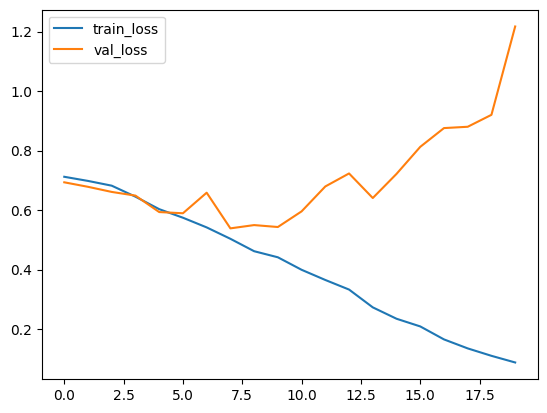

In [60]:
# Let's plot the results
val_loss = history.history["val_loss"]
train_loss = history.history["loss"]

plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend()


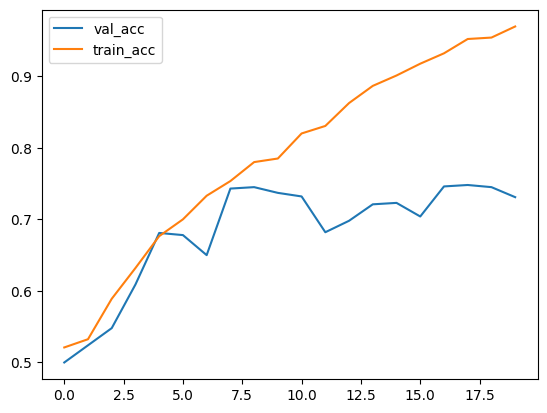

In [61]:
val_acc = history.history["val_accuracy"]
train_acc = history.history["accuracy"]
plt.plot(val_acc, label="val_acc")
plt.plot(train_acc, label="train_acc")
plt.legend()


The overfit is obvious after the 10th epoch. The val_loss is increasing again while the val_accuracy is stable

In [63]:
# Let's load the best model and test on the test set
test_model = keras.models.load_model("models/convnet_from_scratch.keras")
_, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.7461 - loss: 0.5420
Test accuracy: 0.735


## Data Augmentation to Increase Accuracy
Data augmentation takes generates more training data from existing training samples by augmenting the samples via a number of random transformations that yield believable-looking images. In the case of limited samples, this helps expose the model to more aspects of the data so it can generalize better.

In [66]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

To further fight overfitting, we’ll also add a Dropout layer to our model right before the densely connected classifier

In [69]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)  # Applying Data Augmentation
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x) # Adding a dropout layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
  
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [70]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 651ms/step - accuracy: 0.5158 - loss: 0.7151 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.5071 - loss: 0.6934 - val_accuracy: 0.5050 - val_loss: 0.6915
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 565ms/step - accuracy: 0.5218 - loss: 0.6912 - val_accuracy: 0.6060 - val_loss: 0.6788
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 579ms/step - accuracy: 0.5460 - loss: 0.6868 - val_accuracy: 0.5010 - val_loss: 0.8638
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 610ms/step - accuracy: 0.5996 - loss: 0.6736 - val_accuracy: 0.5230 - val_loss: 0.7032
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 599ms/step - accuracy: 0.6369 - loss: 0.6515 - val_accuracy: 0.6320 - val_loss: 0.6437
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 608ms/step - accuracy: 0.6198 - loss: 0.6561 - val_accuracy: 0.6470 - val_loss: 0.6445
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 626ms/step - accuracy: 0.6523 - loss: 0.6466 - 

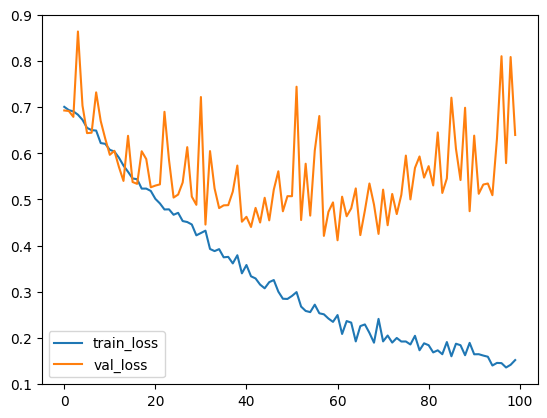

In [71]:
from matplotlib import pyplot as plt
val_loss = history.history["val_loss"]
train_loss = history.history["loss"]

plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend()

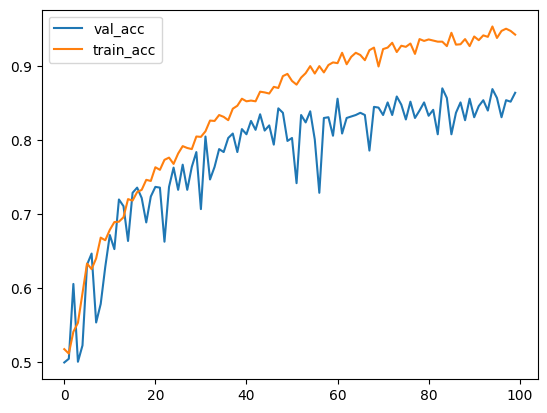

In [72]:
val_acc = history.history["val_accuracy"]
train_acc = history.history["accuracy"]
plt.plot(val_acc, label="val_acc")
plt.plot(train_acc, label="train_acc")
plt.legend()

In [74]:
test_model = keras.models.load_model("models/convnet_from_scratch.keras")
_, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.8508 - loss: 0.4505
Test accuracy: 0.842


# Leveraging a pretrained model
Such portability of learned features across different problems is a key advantage of deep learning compared to many older,
 shallow learning approaches, and it makes deep learning very effective for small-data problems.
 
There are two ways to use a pretrained model: feature extraction and fine-tuning. We’ll cover both of them. Let’s start with feature extraction.

<br>

## Feature extraction with a pretrained model
Feature extraction consists of using the representations learned by a previously trained model to extract interesting features from new samples.
These features are then run through a new classifier, which is trained from scratch.

Convnets used for image classification comprise two parts:
1. A series of pooling and convolution layers (the convolutional base of the model). 
2. Then, a densely connected classifier.

**Feature extraction** consists of taking the convolutional base of a previously trained network, running the new data through it,
and training a new classifier on top of the output

![alt text](static/feature_extraction.png "Feature Extraction")

**Why not taking the classifier too?**
The representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained—they will only contain information about the presence probability of this or that class in the entire picture٫

**Earlier Layers vs Later Layers:**
The level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), whereas layers that are higher up extract more-abstract concepts (such as “cat ear” or “dog eye”). So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

In [75]:
# include_top refers to including (or not) the densely connected classifier on top of the network.
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet", # VGG pretrained on Imagenet Dataset. The imagenet dataset has many dogs and cats thus it'll work with our problem. 
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [76]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Now there are two options:
- Run the convolutional base over our dataset, record its output to a NumPy array on disk, and then use this data as input to a standalone, densely connected classifier. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image. Data augmentation can't be used here.

- Extend the model we have (conv_base) by adding Dense layers on top, and run the whole thing from end to end on the input data. This will allow us to use data augmentation, but it is very expensive compared to the first one.


## Feature Extraction without Data Augmentation
As the images are processed by the convolutional base, you record the output of the last convolutional layer to a NumPy array. This output is a high-dimensional representation of the features extracted from each image. Each image in your dataset corresponds to a row in the NumPy array, and the columns represent the different features extracted by the convolutional base.

We’ll start by extracting features as NumPy arrays by calling the predict() method of the conv_base model on our training, validation, and testing datasets.



In [98]:
import numpy as np
  
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        # resizes images to fit the new model
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
  
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

2024-04-17 22:49:20.771075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

2024-04-17 22:50:58.179759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 

2024-04-17 22:55:31.157441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [99]:
# The extracted features are currently of shape (samples, 5, 5, 512):
train_features.shape

(2000, 5, 5, 512)

# Now we densely connected layer on the top

In [100]:
inputs = keras.Input(shape=(5, 5, 512))
# We start with flatten to flatten the previous input
x = layers.Flatten()(inputs)               
# Then we can add as many densley connected layer as needed
x = layers.Dense(256)(x)
# Why not adding a Dropout layer?
x = layers.Dropout(0.5)(x)
# And finally a dense layer with 1 unit for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
  
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    # Note how these values are fed to the model, features and labels are fed separately
    train_features, train_labels,
    epochs=20,
    # Note how these values are fed to the model, features and labels are fed separately
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8611 - loss: 27.4675 - val_accuracy: 0.9720 - val_loss: 2.2944
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9649 - loss: 4.6538 - val_accuracy: 0.9230 - val_loss: 21.2613
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9781 - loss: 4.5304 - val_accuracy: 0.9760 - val_loss: 4.9483
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9672 - loss: 9.7593 - val_accuracy: 0.9720 - val_loss: 7.6347
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9914 - loss: 1.5726 - val_accuracy: 0.9660 - val_loss: 14.9033
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9968 - loss: 1.6381 - val_accuracy: 0.9670 - val_loss: 14.1922
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9951 - loss: 1.2671 - val_accuracy: 0.9660 - val_loss: 13.6380
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9951 - loss: 1.0205 - val_accuracy: 0.972

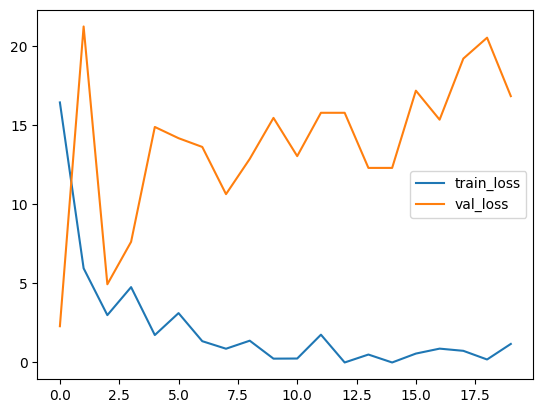

In [101]:
val_loss = history.history["val_loss"]
train_loss = history.history["loss"]

plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend()

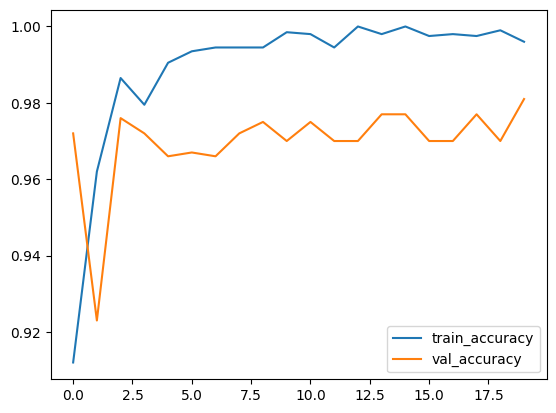

In [102]:
val_acc = history.history["val_accuracy"]
train_acc = history.history["accuracy"]

plt.plot(train_acc, label="train_accuracy")
plt.plot(val_acc, label="val_accuracy")
plt.legend()

The plots also indicate that we’re overfitting almost from the start—despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets. 

## Feature Extraction with Data Augmentation
 Creating a model that chains the conv_base with a new dense classifier, and training it end to end on the inputs.

In [35]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
# Preventing conv_base weights from being updated during training
conv_base.trainable = False

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
inputs = keras.Input(shape=(180, 180, 3))
# Apply data augmentation
x = data_augmentation(inputs)
#  Apply input value scaling
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)               
# Then we can add as many densley connected layer as needed
x = layers.Dense(256)(x)
# Why not adding a Dropout layer?
x = layers.Dropout(0.5)(x)
# And finally a dense layer with 1 unit for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
  
# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         filepath="models/feature_extraction.keras",
#         save_best_only=True,
#         monitor="val_loss")
# ]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    # callbacks=callbacks
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 487ms/step - accuracy: 0.8179 - loss: 45.8952 - val_accuracy: 0.9120 - val_loss: 16.5099
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 996ms/step - accuracy: 0.9429 - loss: 6.8267 - val_accuracy: 0.9600 - val_loss: 3.4058
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9522 - loss: 5.9997 - val_accuracy: 0.9810 - val_loss: 2.5590
Epoch 4/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 12:46 12s/step - accuracy: 0.1875 - loss: 6.8583

In [ ]:
val_loss = history.history["val_loss"]
train_loss = history.history["loss"]

plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend()


In [ ]:
val_acc = history.history["val_accuracy"]
train_acc = history.history["accuracy"]

plt.plot(train_acc, label="train_accuracy")
plt.plot(val_acc, label="val_accuracy")
plt.legend()

## Fine-tuning a Pretrained Model

**Fine-tuning** consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers.

**Important Note:** it’s only possible to fine-tune the top layers (closer to the output) of the convolutional base once the classifier on top has already been trained. If the classifier isn’t already trained, the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed.

The steps for fine-tuning a network are as follows:
1. Add our custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added (basically the whole thing but since the base is frozen it'll be only the part we added.).
4. Unfreeze some layers in the base network. (Note that you should not unfreeze “batch normalization” layers, which are not relevant here since there are no such layers in VGG16. Batch normalization and its impact on fine-tuning is explained in the next chapter.)
5. Jointly train both these layers and the part we added.


The author fine-tunes the last three convolutional layers. Why not more or less?  Consider the following before you decide:

- Earlier layers in the convolutional base encode more generic, reusable features, whereas layers higher up encode more specialized features. It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on your new problem. There would be fast-decreasing returns in fine-tuning lower layers.

- The more parameters you’re training, the more you’re at risk of overfitting. The convolutional base has 15 million parameters, so it would be risky to attempt to train it on your small dataset.


In [8]:
# Unfreezing the last three layers only
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
# Preventing conv_base weights from being updated during training
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

We'll use a small learning rat to limit the magnitude of the modifications we make to the representations of the three layers we’re fine-tuning

In [9]:
from tensorflow.keras import layers
from tensorflow import keras

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
inputs = keras.Input(shape=(180, 180, 3))
# Apply data augmentation
x = data_augmentation(inputs)
#  Apply input value scaling
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)               
# Then we can add as many densley connected layer as needed
x = layers.Dense(256)(x)
# Why not adding a Dropout layer?
x = layers.Dropout(0.5)(x)
# And finally a dense layer with 1 unit for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
  
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 463ms/step - accuracy: 0.6901 - loss: 5.5352 - val_accuracy: 0.9300 - val_loss: 0.5812
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 712ms/step - accuracy: 0.8642 - loss: 1.3374 - val_accuracy: 0.9610 - val_loss: 0.3419
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 885ms/step - accuracy: 0.9150 - loss: 0.5829 - val_accuracy: 0.9600 - val_loss: 0.2825
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 811ms/step - accuracy: 0.9341 - loss: 0.3627 - val_accuracy: 0.9630 - val_loss: 0.2451
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 810ms/step - accuracy: 0.9361 - loss: 0.2593 - val_accuracy: 0.9630 - val_loss: 0.2233
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 810ms/step - accuracy: 0.9409 - loss: 0.3284 - val_accuracy: 0.9670 - val_loss: 0.1968
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 846ms/step - accuracy: 0.9561 - loss: 0.1882 - val_accuracy: 0.9670 - val_loss: 0.1666
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 706ms/step - accuracy: 0.9643 - loss: 0.1600 - val_accu

In [10]:
model = keras.models.load_model("models/fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

ValueError: File not found: filepath=models/fine_tuning.keras. Please ensure the file is an accessible `.keras` zip file.